# Yeast cells detection sample notebook

This pipeline detects, segments, and tracks yeast cells in time-series microscopy data. It uses a mask-RCNN model trained on synthetic brightfield budding yeast cell data to detect and segment the cells. For tracking, the clustering algorithm DBSCAN is used with input distances based on the intersection-over-union metric. The cell (tracking) label, its centroid position, and area in pixels are extracted.

In [ ]:
try:
  from yeastcells import data, features, yit, segmentation, tracking, visualize
except ImportError:
  # Outside of colab, it is necesary to manually install scikit-learn, seaborn, torch and torchvision, e.g.:
  # !pip3 install scikit-learn torch torchvision seaborn
  !pip3 install -U pyyaml # resolves: FileNotFoundError: [Errno 2] No such file or directory: '/usr/local/lib/python3.7/dist-packages/PyYAML-3.13.dist-info/METADATA
  !pip3 install -U git+https://github.com/ymzayek/yeastcells-detection-maskrcnn.git
  from yeastcells import data, features, yit, segmentation, tracking, visualize

In [ ]:
%matplotlib inline

import os
import seaborn
import tifffile
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from skimage.io import imread
from download import download
import matplotlib.pyplot as plt

## Download model and data

If downloading the model or data results in a time out, please try again. If the download aborts midway, also try again since downloads will continue.

This zip is only re-extracted if the folder doesn't exist or it's content is less than 500MB.

On colab, you can browse the files via the left bar.

In [ ]:
# pipeline_path = f'/content/yeastcells-detection-maskrcnn'
pipeline_path = f'../'

download(
    'https://datascience.web.rug.nl/models/yeast-cells/mask-rcnn/v1/model_final.pth',
    f'{pipeline_path}/model_final.pth')

download(
    'https://datascience.web.rug.nl/YIT-Benchmark2.zip', 
    f'{pipeline_path}/YIT-Benchmark2/YIT-Benchmark2.zip')

# Extract the YIT-Benchmark2.zip if the folder doesn't exist or the content is
# smaller than 500MB (heuristic).
extracted_size = !du -s '{pipeline_path}/YIT-Benchmark2/'
if not os.path.exists(f'{pipeline_path}/YIT-Benchmark2/') or \
   int(''.join(extracted_size).split()[0]) < 500*1024: 
  !cd '{pipeline_path}' && unzip -o 'YIT-Benchmark2/YIT-Benchmark2.zip' -d YIT-Benchmark2
else:
  print('It seems the YIT-Benchmark2 data set is extracted alread extracted')

testset = 'TestSet1'
filenames = data.load_data(f'{pipeline_path}/YIT-Benchmark2/{testset}/RawData', ff = '.tif')

Replace is False and data exists, so doing nothing. Use replace=True to re-download the data.
Replace is False and data exists, so doing nothing. Use replace=True to re-download the data.
It seems the YIT-Benchmark2 data set is extracted alread extracted


## Read movie

Ensure the image is either shaped $frames \times height \times width \times 3$ or $height \times width \times 3$ for a still image. The 3 channels should be the same, and intensities should range `[0, 255]` and be of type `np.uint8`, although alternative representations might also work.



In [ ]:
assert len(filenames) > 0, "No images were found"

image = [imread(filename) for filename in filenames]

assert len({im.shape for im in image}) == 1, (
    f"Images have inconsistent shapes: "
    f"{', '.join({'x'.join(map(str, im.shape)) for im in image})}")

image = np.concatenate([frame[None, ..., None] * [[[1.,1.,1.]]] for frame in image])
image = (255 * image / image.max()).astype(np.uint8)
image.shape # (frames, length, width, channels)

(60, 512, 512, 3)

## Apply Mask-RCNN model

The Mask-RCNN model segments yeast cells in each frame independently. The output is a structure where every cell is represented as an instance of bounding boxes, masks and probability scores.

For example, one can access the 13th bounding box in the 7th time frame like this.

    x0, y0, x1, y1 = np.array(output[6]['instances'].pred_boxes.tensor.to('cpu')[12])

In [ ]:
detections, masks = segmentation.get_segmentation(
  image, f'{pipeline_path}/model_final.pth', seg_thresh=0.955, device='cuda:0')

## Tracking detections across time frames

`tracked_cells` marks the centroids of each detection in a dataframe with columns `frame`, `x` and `y`, and a column `cell` to track the cells. Negative values (-1) mark outliers that were not tracked.

These tracks are plot in 3D.

In [ ]:
detections = tracking.track_cells(detections, masks, dmax=5, min_samples=3, eps=0.6, device='cuda:0')

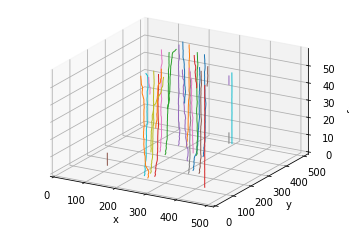

In [ ]:
# plot yeast cell positions over time

ax = visualize.plot_paths(detections, style={'linewidth': 1}, xlim=(0, 512), ylim=(0, 512), title='',)

## Visualize as a movie

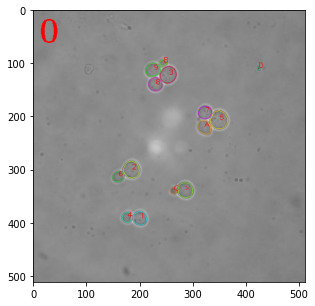

In [ ]:
# Creates a colorfull stack of images, each cell is drawn as a polygon in
# the same color across frames, and can be labeled.
scene = visualize.create_scene(image, detections, masks,
                               frame_style={}, label_style={})

# When interactive plotting is available, this can be animated. Otherwise
# a still image of the first frame is shown.

movie = visualize.show_animation(scene, title='', delay=700) 

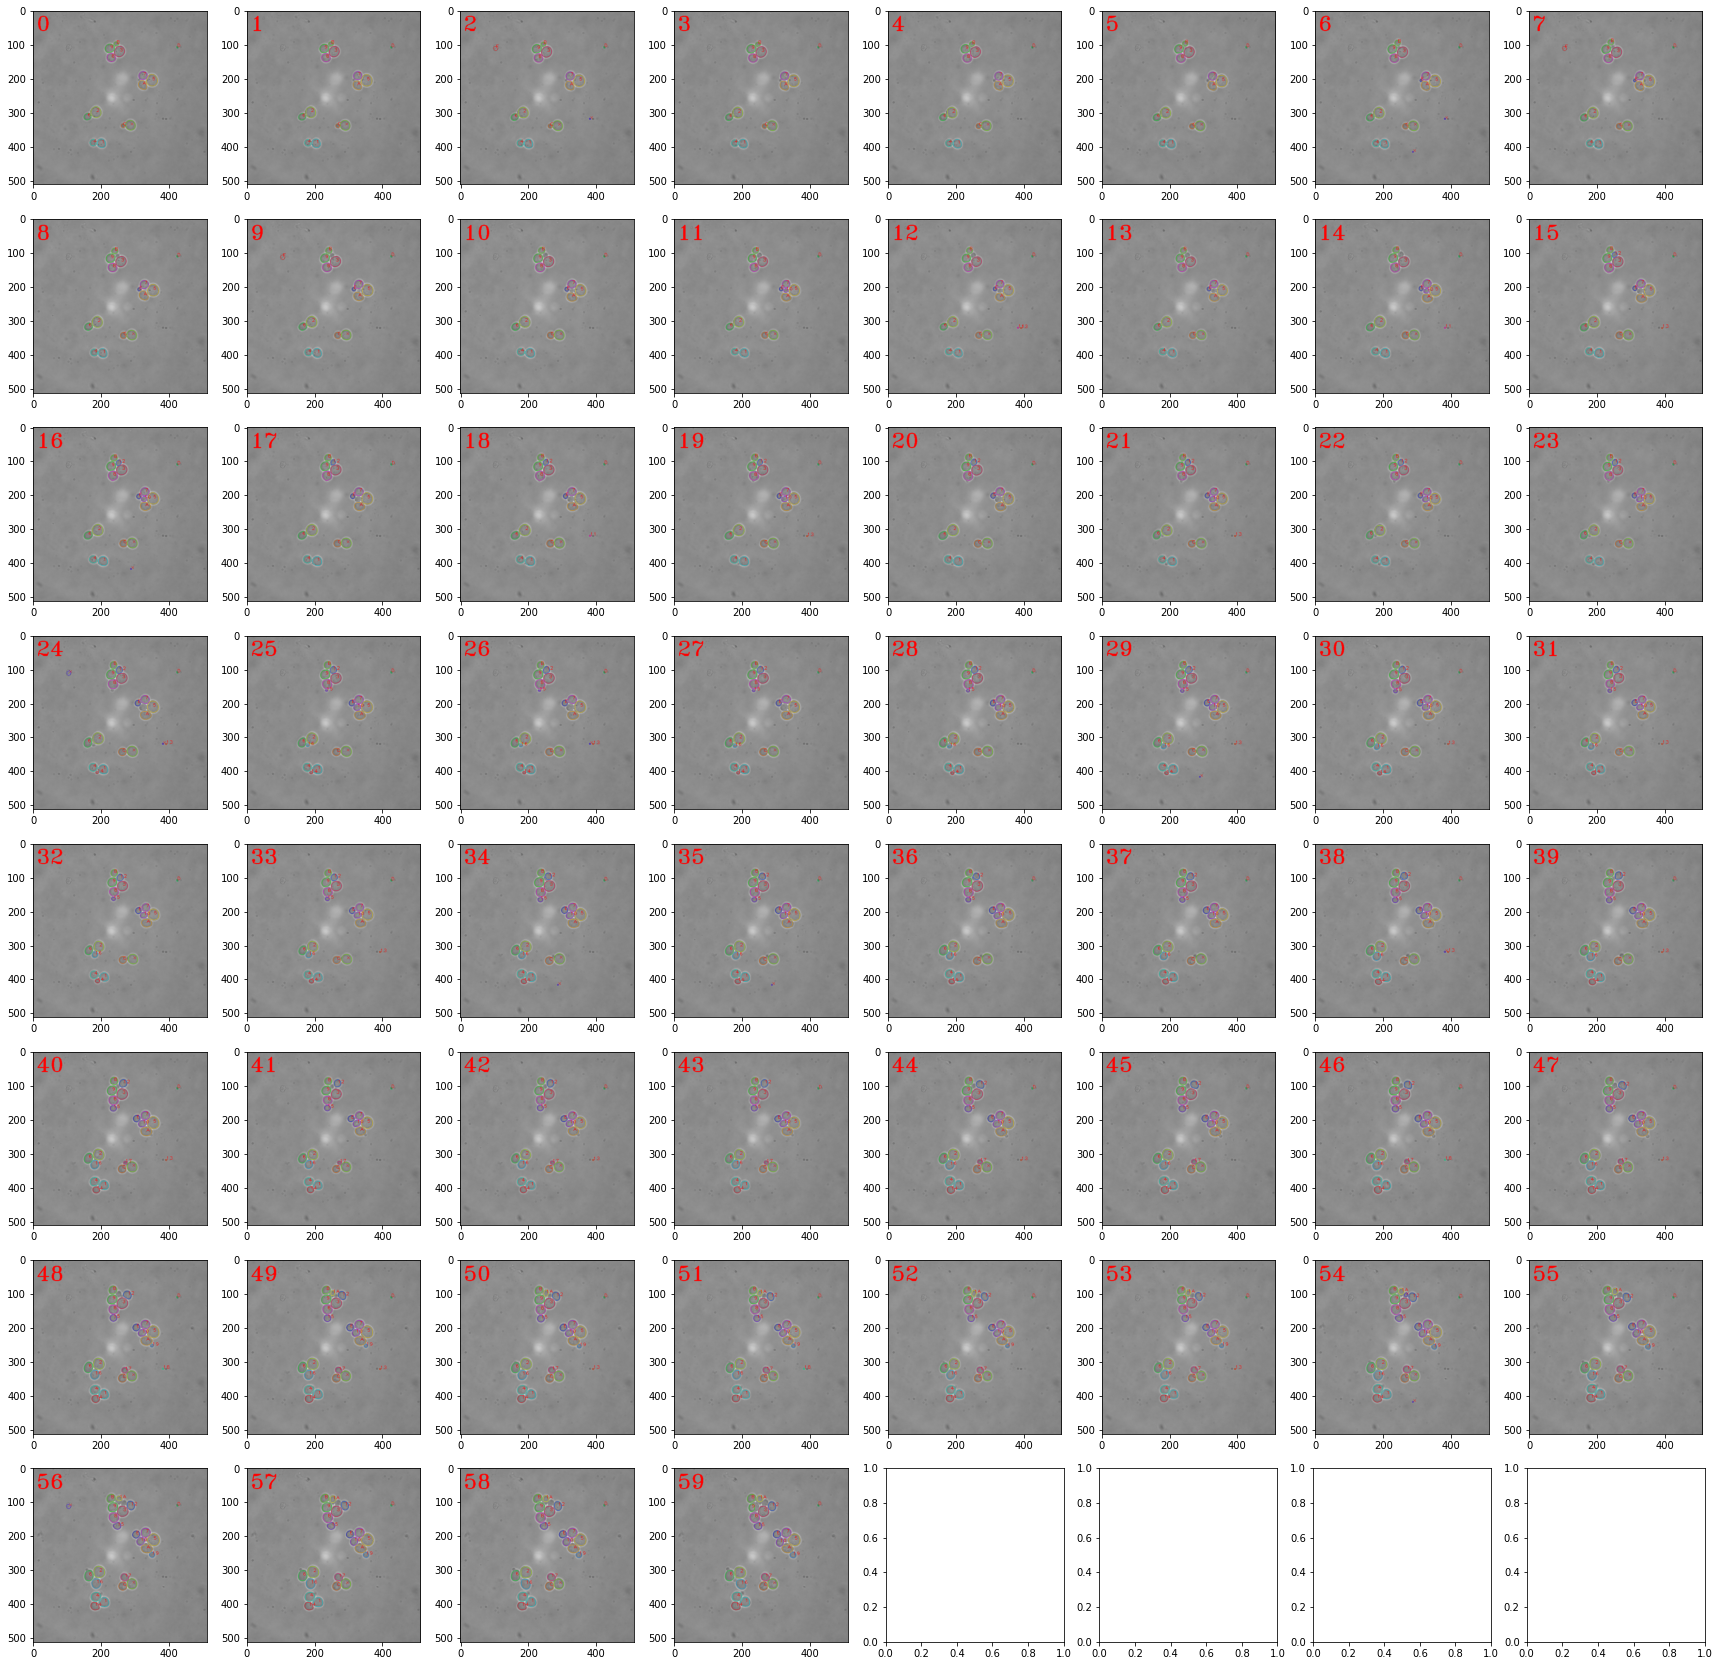

In [ ]:
# Alternatively, plot every frame independently
axes = plt.subplots(8, 8, figsize=(30, 30))[1].ravel()
for axis, frame in zip(axes, scene):
  axis.imshow(frame)

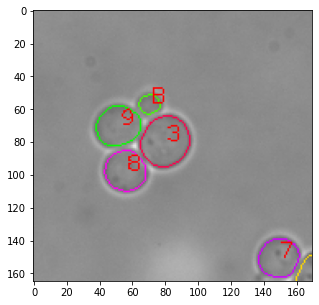

In [ ]:
# One may extract the one particular cell, e.g. 3, in time and spatial dimensions
cell_scene = visualize.select_cell(scene, detections, 3, w=80)

movie = visualize.show_animation(cell_scene, title='', delay=500)

## Output as a DataFrame (or spreadsheet)

This creates a dataframe with columns for time, frame number, cell number, position and the cell area. Of course, other features could be added when needed.

This dataframe can be exported to excel or csv spreadsheets.

In [ ]:
detections['area'] = features.get_areas(masks)
detections['pixel intensity'] = features.get_pixel_value_sum(image[..., 0], detections, masks)
detections['mean pixel intensity'] = detections['pixel intensity'] / detections['area']
detections

,frame,cell,mask,x,y,segmentation_score,area,pixel intensity,mean pixel intensity
0,0,0,0,286.410334,338.782675,0.999553,658,84172,127.920973
1,0,1,1,200.996161,391.641075,0.999402,521,67453,129.468330
2,0,2,2,184.955556,300.231373,0.999191,765,100620,131.529412
3,0,3,3,254.209893,121.577540,0.999078,748,99092,132.475936
4,0,4,4,176.620805,389.728188,0.998882,298,37372,125.409396
...,...,...,...,...,...,...,...,...,...
1165,59,3,1165,263.167546,126.907652,0.995333,758,101478,133.875989
1166,59,26,1166,252.303249,90.093863,0.986117,277,36274,130.953069
1167,59,10,1167,333.720395,237.129934,0.985839,608,80718,132.759868
1168,59,9,1168,228.451411,116.134796,0.981210,319,42893,134.460815


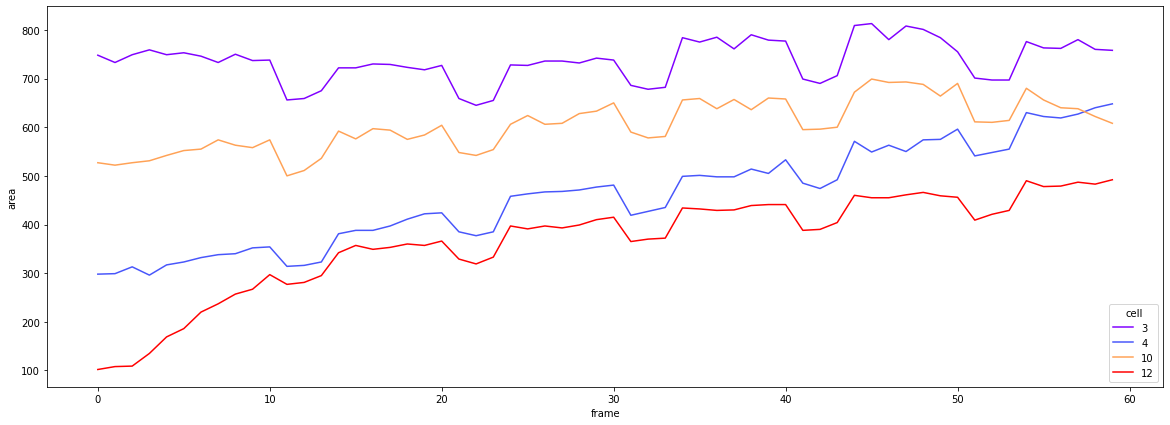

In [ ]:
plt.figure(figsize=(20, 7))
seaborn.lineplot(
  data = detections[detections['cell'].isin([3, 4, 12, 10])],
  x='frame', hue='cell', palette='rainbow',
  y='area',
  # y='pixel intensity',
  # y='mean pixel intensity',
)

In [ ]:
try:
  from google.colab.files import download
  detections.to_excel('cell detections.xlsx')
  download('cell detections.xlsx')
except ImportError:
  print('Not on Google Colab, won\'t start download')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Detection statistics

`pandas` allows finding cell statistics, for example

    # Number of tracked frames for each cell:
    detections['cell'].value_counts()

    # Number of detections:
    len(detections)

    # Detections per frame
    detections['frame'].value_counts()

Note that cells labeled with a -1 were unable to be tracked

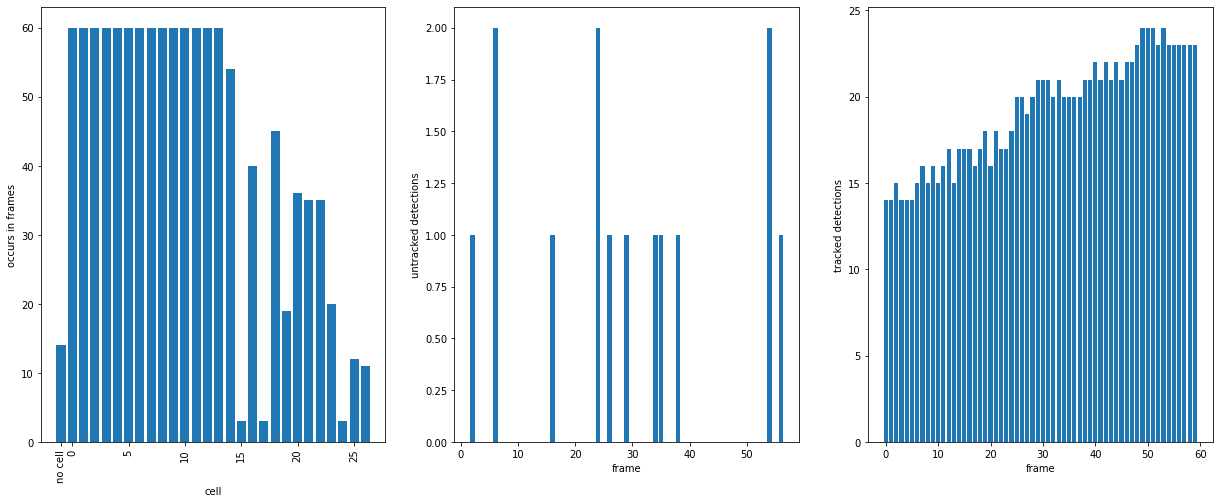

In [ ]:
_, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(21, 8))

detections_per_cells = detections['cell'].value_counts()
ax0.bar(detections_per_cells.index, detections_per_cells.values)
ax0.set_xlabel('cell'); ax0.set_ylabel('occurs in frames')
ax0.set_xticks([-1, 0, 5, 10, 15, 20, 25])
ax0.set_xticklabels(['no cell', 0, 5, 10, 15, 20, 25],  rotation=90)


detections_per_frame = detections[detections['cell'] == -1]['frame'].value_counts()
ax1.bar(detections_per_frame.index, detections_per_frame.values)
ax1.set_xlabel('frame'); ax1.set_ylabel('untracked detections')

detections_per_frame = detections[detections['cell'] >= 0]['frame'].value_counts()
ax2.bar(detections_per_frame.index, detections_per_frame.values)
ax2.set_xlabel('frame'); ax2.set_ylabel('tracked detections')
None

## Export masks as tiff stack file


In [ ]:
masks_out = 'masks.tif'
with tifffile.TiffWriter(masks_out) as stack:
  for m in masks:
      stack.save(m)

try:
  from google.colab.files import download
  download('masks.tif')
except ImportError:
  print('Not on Google Colab, won\'t start download')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>